In [6]:
# Filsti
file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/times_NK800_SST_PO.asc"

# Laste inn data
df_temp = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Navngi kolonnene (Antar at første tre kolonner er år, måned, dag, resten er temperaturer)
num_columns = df_temp.shape[1]
column_names = ['Year', 'Month', 'Day'] + [f'PO_{i+1}' for i in range(num_columns - 3)]
df_temp.columns = column_names

# Konverter dato til datetime-format
df_temp['Dato'] = pd.to_datetime(df_temp[['Year', 'Month', 'Day']])

# Sortere etter dato
df_temp = df_temp.sort_values(by='Dato')


# Fjerne de separate år/måned/dag-kolonnene
df_temp = df_temp.drop(columns=['Year', 'Month', 'Day'])

#gjør om til månedlig gjennomsnitt med 2 desimaler
df_temp['Dato'] = pd.to_datetime(df_temp['Dato'])
df_temp.set_index('Dato', inplace=True)
df_temp = df_temp.resample('M').mean().round(2)
# Tilbakestill indeksen for å få 'Dato' tilbake som en kolonne
df_temp.reset_index(inplace=True)

# gjør slik at PO er en egen kolonne med verdiene i PO_1, PO_2 osv.
df_temp = df_temp.melt(id_vars=['Dato'], var_name='PO', value_name='Temperature')

#Gjør slik at PO ikke skrives som PO_1, PO_2 osv. men som 1,0 , 1,2 osv
df_temp["PO"] = df_temp["PO"].str.replace("PO_", "").astype(float)

df_temp.set_index("Dato", inplace=True)
#viser litt mer av dataene

# Lagre den behandlede dataen til en ny CSV-fil
output_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/temp_po.csv"
df_temp.to_csv(output_path, index=False, sep=';')
print(f"\nData lagret til {output_path}")

df_temp.head(20)




Data lagret til /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/temp_po.csv


,PO,Temperature
Dato,,
2012-01-31,1.0,4.92
2012-02-29,1.0,2.91
2012-03-31,1.0,4.44
2012-04-30,1.0,6.02
2012-05-31,1.0,9.95
2012-06-30,1.0,13.44
2012-07-31,1.0,16.54
2012-08-31,1.0,17.97
2012-09-30,1.0,15.40


In [67]:
import pandas as pd
import os

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/biostat-total-flk.csv"

df_biostat_fylke = pd.read_csv(file_path, sep=";", decimal=".", na_values=["(null)"])
df_biostat_fylke = df_biostat_fylke[df_biostat_fylke["ARTSID"] == "LAKS"].copy()

df_biostat_fylke['Dato'] = pd.to_datetime(
    df_biostat_fylke['ÅR'].astype(str) + '-' + df_biostat_fylke['MÅNED_KODE'].astype(str),
    format='%Y-%m',
    errors='coerce'
)

df_biostat_fylke = df_biostat_fylke[['Dato'] + [col for col in df_biostat_fylke.columns if col != 'Dato']]
df_biostat_fylke['Dato'] = df_biostat_fylke['Dato'] + pd.offsets.MonthEnd(0)

df_biostat_fylke = df_biostat_fylke.dropna(subset=['FYLKE'])
df_biostat_fylke = df_biostat_fylke[df_biostat_fylke['FYLKE'] != 'Uoppgitt']

df_biostat_fylke = df_biostat_fylke.drop(columns=[
    'ÅR', 'MÅNED_KODE', 'MÅNED', 'UTSETTSÅR', 'ARTSID',
    'UTSETT_SMOLT_STK', 'UTSETT_SMOLT_STK_MINDRE_ENN_500G',
    'UTTAK_STK', 'UTTAK_KG', 'UTTAK_SLØYD_KG', 'UTTAK_HODEKAPPET_KG',
    'UTTAK_RUNDVEKT_KG', 'UTKAST_STK', 'RØMMING_STK', 'ANDRE_STK'
])

df_biostat_fylke['% Dødfisk'] = df_biostat_fylke['DØDFISK_STK'] / df_biostat_fylke['BEHFISK_STK'] * 100

# --- Definer mapping fra fylke til PO og vekter ---
fylke_til_po_map = {
    'Rogaland og Agder': {1: 0.4, 2: 0.6},
    'Vestland': {3: 0.55, 4: 0.45},
    'Møre og Romsdal': {5: 0.5, 6: 0.5},
    'Trøndelag': {6: 0.6, 7: 0.4},
    'Nordland': {7: 0.09, 8: 0.38, 9: 0.28, 10: 0.25},
    'Troms og Finnmark': {10: 0.25, 11: 0.25, 12: 0.35, 13: 0.15},
    'Troms': {10: 0.5, 11: 0.5},
    'Finnmark': {12: 0.6, 13: 0.4},
}

# --- Fordel data basert på vektene ---
po_rows = []
for idx, row in df_biostat_fylke.iterrows():
    fylke = row['FYLKE']
    if fylke in fylke_til_po_map:
        po_weights = fylke_til_po_map[fylke]
        for po, weight in po_weights.items():
            new_row = row.copy()
            for col in ['BEHFISK_STK', 'BIOMASSE_KG', 'FORFORBRUK_KG', 'DØDFISK_STK']:
                if col in new_row and pd.notnull(new_row[col]):
                    new_row[col] = new_row[col] * weight
            new_row['PO'] = po
            po_rows.append(new_row)

df_biostat_po_temp = pd.DataFrame(po_rows)

# --- Aggregér PO-data ---
aggregation_rules = {
    'BEHFISK_STK': 'sum',
    'BIOMASSE_KG': 'sum',
    'FORFORBRUK_KG': 'sum',
    'DØDFISK_STK': 'sum',
}
cols_to_aggregate = {col: rule for col, rule in aggregation_rules.items() if col in df_biostat_po_temp.columns}

if cols_to_aggregate:
    df_biostat_po = df_biostat_po_temp.groupby(['Dato', 'PO'], as_index=False).agg(cols_to_aggregate)

    # Kalkuler på nytt
    df_biostat_po['% Dødfisk'] = (
        df_biostat_po['DØDFISK_STK'] / df_biostat_po['BEHFISK_STK'].replace(0, pd.NA) * 100
    ).fillna(0)
else:
    df_biostat_po = df_biostat_po_temp.drop_duplicates(subset=['Dato', 'PO']).copy()

if 'FYLKE' in df_biostat_po.columns:
    df_biostat_po = df_biostat_po.drop(columns=['FYLKE'])

df_biostat_po = df_biostat_po.sort_values(by=['PO', 'Dato'])

#Kutt data til 2012 og legg til forforbruk per biomasse
df_biostat_po = df_biostat_po[df_biostat_po['Dato'] >= '2012-01-01']

#forforbruk i kg per biomasse i kg slik at det kan sammenlignes over forskjellige PO
df_biostat_po['% FORFORBRUK'] = df_biostat_po['FORFORBRUK_KG'] / df_biostat_po['BIOMASSE_KG']
#gjør om til prosent
df_biostat_po['% FORFORBRUK'] = df_biostat_po['% FORFORBRUK'] * 100

#legger til tetthet i PO som kolonne km^2
arealPO1 = 4598
arealPO2 = 2439
arealPO3 = 5681
arealPO4 = 7138
arealPO5 = 7138
arealPO6 = 12308
arealPO7 = 5412
arealPO8 = 13106
arealPO9 = 16740
arealPO10 = 4795
arealPO11 = 7108
arealPO12 = 11196
arealPO13 = 4172

# --- Lag en mapping fra PO til areal ---
po_areal_map = {
    1: arealPO1, 2: arealPO2, 3: arealPO3, 4: arealPO4, 5: arealPO5,
    6: arealPO6, 7: arealPO7, 8: arealPO8, 9: arealPO9, 10: arealPO10,
    11: arealPO11, 12: arealPO12, 13: arealPO13
}

# --- Beregn Tetthet for df_biostat_po ved å bruke mappingen ---
# Map PO-nummer til tilhørende areal
df_biostat_po['Areal_PO'] = df_biostat_po['PO'].map(po_areal_map)

# Beregn Tetthet (Biomasse / Areal)
# Bruk .replace(0, pd.NA) for å unngå divisjon med null hvis et areal er 0
df_biostat_po['Tetthet'] = (df_biostat_po['BIOMASSE_KG'] / df_biostat_po['Areal_PO'].replace(0, pd.NA)).fillna(0)

# Fjern hjelpekolonnen for areal hvis ønskelig
df_biostat_po = df_biostat_po.drop(columns=['Areal_PO'])

# Vis resultat
print("\ndf_biostat_po med Tetthet beregnet:")
print(df_biostat_po.head(5))


df_biostat_po med Tetthet beregnet:
           Dato  PO  BEHFISK_STK  BIOMASSE_KG  FORFORBRUK_KG  DØDFISK_STK  \
1092 2012-01-31   1   12612103.6  24749310.32      3767059.6      72884.0   
1105 2012-02-29   1   11659039.2  23071582.60      2797140.8      81142.4   
1118 2012-03-31   1   10871338.0  20850721.60      2946169.2      89078.8   
1131 2012-04-30   1   11542926.4  17931829.40      2600076.0      88236.8   
1144 2012-05-31   1   11057955.2  17248389.80      2846917.2     114782.4   

      % Dødfisk  % FORFORBRUK      Tetthet  
1092   0.577889     15.220867  5382.625124  
1105   0.695961     12.123749  5017.743062  
1118   0.819391     14.129819  4534.737190  
1131   0.764423     14.499781  3899.919400  
1144   1.038007     16.505409  3751.280948  


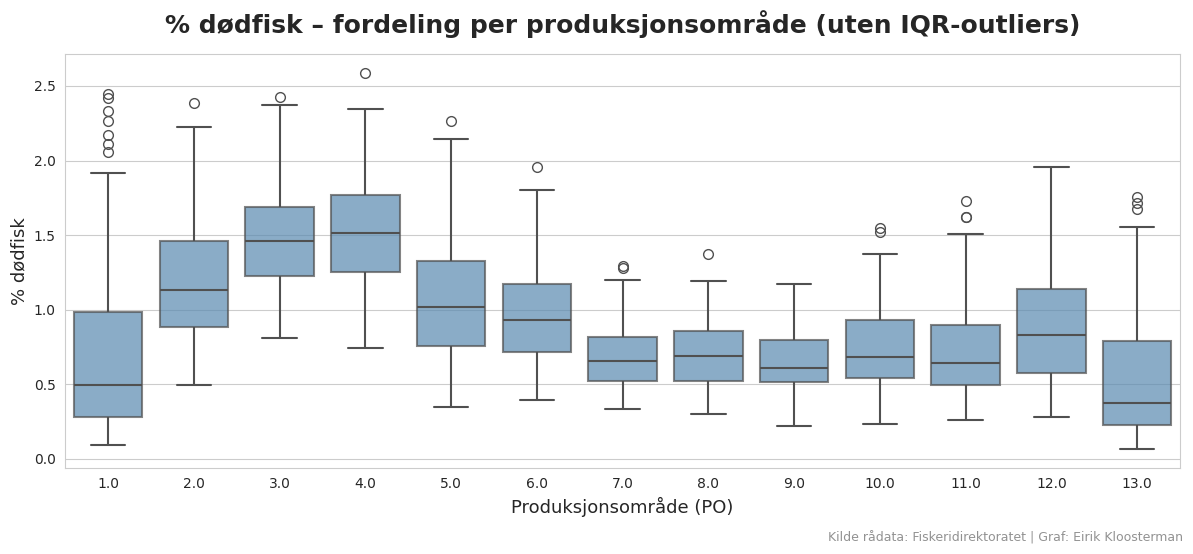


Data lagret til /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/biostat_po.csv


,Dato,PO,BEHFISK_STK,BIOMASSE_KG,FORFORBRUK_KG,DØDFISK_STK,% Dødfisk,Tetthet,% FORFORBRUK
0,2017-10-31,1.0,6902756,5596158.262,1415658,16264,0.235616,1217.085311,25.296961
1,2017-11-30,1.0,6786911,6490275.110,1538043,21422,0.315637,1411.543086,23.697655
2,2017-12-31,1.0,6605088,7481594.271,1679961,21594,0.326930,1627.140990,22.454586
3,2018-01-31,1.0,6286393,7593363.087,1215392,15974,0.254104,1651.449127,16.005978
4,2018-02-28,1.0,5699273,5137993.807,648529,9176,0.161003,1117.441019,12.622222


In [68]:
file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/biostat-total-omr.csv"
import pandas as pd
import matplotlib.pyplot as plt

# Laste inn data
df_biostat = pd.read_csv(file_path, sep=';')
df_biostat = pd.read_csv(file_path, sep=";", decimal=".", na_values=["(null)"])
df_biostat = df_biostat[df_biostat["ARTSID"] == "LAKS"].copy()
df_biostat

#csvfilen har kolonner: år;måned_kode;måned;PO_KODE;PO_NAVN;ARTSID;UTSETTSÅR;BEHFISK_STK;BIOMASSE_KG;UTSETT_SMOLT_STK;UTSETT_SMOLT_STK_MINDRE_ENN_500G;FORFORBRUK_KG;UTTAK_STK;UTTAK_KG;UTTAK_SLØYD_KG;UTTAK_HODEKAPPET_KG;UTTAK_RUNDVEKT_KG;DØDFISK_STK;UTKAST_STK;RØMMING_STK;ANDRE_STK
# Kolonnene som er relevante for oss er: år, måned, PO_KODE, ARTSID, UTSETTSÅR, BEHFISK_STK, BIOMASSE_KG, DØDFISK_STK
# Vi vil også fjerne de som ikke er relevante for oss
#konverterer til datetime
df_biostat['Dato'] = pd.to_datetime(
    df_biostat['ÅR'].astype(str) + '-' + df_biostat['MÅNED_KODE'].astype(str),
    format='%Y-%m',
    errors='coerce'
)
#setter Dato som første kolonne
df_biostat = df_biostat[['Dato'] + [col for col in df_biostat.columns if col != 'Dato']]

#gjør siste dag i måneden til dato
df_biostat['Dato'] = df_biostat['Dato'] + pd.offsets.MonthEnd(0)

#fjerner alle rader NaN i PO_KODE
df_biostat = df_biostat.dropna(subset=['PO_KODE'])
#endrer navn på kolonne
df_biostat.rename(columns={'PO_KODE': 'PO'}, inplace=True)

#fjerner kolonner
df_biostat = df_biostat.drop(columns=['ÅR', 'MÅNED_KODE', 'MÅNED', 'PO_NAVN', 'UTSETTSÅR', 'ARTSID',"UTSETT_SMOLT_STK", 'UTSETT_SMOLT_STK_MINDRE_ENN_500G', 'UTTAK_STK', 'UTTAK_KG', 'UTTAK_SLØYD_KG', 'UTTAK_HODEKAPPET_KG', 'UTTAK_RUNDVEKT_KG', 'UTKAST_STK', 'RØMMING_STK', 'ANDRE_STK'])

#legger til %dødfisk som kolonne
df_biostat = df_biostat.groupby(['Dato', 'PO'], as_index=False).agg({
    'BEHFISK_STK': 'sum',
    'BIOMASSE_KG': 'sum',
    'FORFORBRUK_KG': 'sum',
    'DØDFISK_STK': 'sum'
})

# Fjern rader der BEHFISK_STK er 0 eller NaN (unngå deling på null)
df_biostat = df_biostat[df_biostat['BEHFISK_STK'] > 0]

# Regn ut % Dødfisk
df_biostat['% Dødfisk'] = df_biostat['DØDFISK_STK'] / df_biostat['BEHFISK_STK'] * 100


#legger til tetthet i PO som kolonne km^2
arealPO1 = 4598
arealPO2 = 2439
arealPO3 = 5681
arealPO4 = 7138
arealPO5 = 7138
arealPO6 = 12308
arealPO7 = 5412
arealPO8 = 13106
arealPO9 = 16740
arealPO10 = 4795
arealPO11 = 7108
arealPO12 = 11196
arealPO13 = 4172

#der tetthet hver måned er et mål på biomasse i kg per m2
df_biostat['Tetthet'] = 0.0
# Konverterer til kg per km2
df_biostat.loc[df_biostat['PO'] == 1, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO1
df_biostat.loc[df_biostat['PO'] == 2, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO2
df_biostat.loc[df_biostat['PO'] == 3, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO3
df_biostat.loc[df_biostat['PO'] == 4, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO4
df_biostat.loc[df_biostat['PO'] == 5, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO5
df_biostat.loc[df_biostat['PO'] == 6, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO6
df_biostat.loc[df_biostat['PO'] == 7, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO7
df_biostat.loc[df_biostat['PO'] == 8, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO8
df_biostat.loc[df_biostat['PO'] == 9, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO9
df_biostat.loc[df_biostat['PO'] == 10, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO10
df_biostat.loc[df_biostat['PO'] == 11, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO11
df_biostat.loc[df_biostat['PO'] == 12, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO12
df_biostat.loc[df_biostat['PO'] == 13, 'Tetthet'] = df_biostat['BIOMASSE_KG'] / arealPO13

#samle data når ett PO har flere rader i samme måned
df_biostat = df_biostat.groupby(['Dato', 'PO']).agg({
    'BEHFISK_STK': 'sum',
    'BIOMASSE_KG': 'sum',
    'FORFORBRUK_KG': 'sum',
    'DØDFISK_STK': 'sum',
    '% Dødfisk': 'mean',
    'Tetthet': 'mean'
}).reset_index()

#forforbruk i kg per biomasse i kg slik at det kan sammenlignes over forskjellige PO
df_biostat['% FORFORBRUK'] = df_biostat['FORFORBRUK_KG'] / df_biostat['BIOMASSE_KG']
#gjør om til prosent
df_biostat['% FORFORBRUK'] = df_biostat['% FORFORBRUK'] * 100


#sortere etter PO
df_biostat = df_biostat.sort_values(by=['PO', 'Dato'])

df_biostat.set_index("Dato", inplace=True)


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

col = "% Dødfisk"

def remove_iqr_outliers(df, group_col, value_col):
    def iqr_filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

df_biostat_iqr = remove_iqr_outliers(df_biostat, "PO", col)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Lato", "DejaVu Sans", "Arial"]

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_biostat_iqr,
    x="PO",
    y=col,
    color="#4B8BBE",
    fliersize=7,
    linewidth=1.5,
    boxprops=dict(alpha=0.7)
)
ax.set_title("% dødfisk – fordeling per produksjonsområde (uten IQR-outliers)", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Produksjonsområde (PO)", fontsize=13)
ax.set_ylabel("% dødfisk", fontsize=13)
plt.suptitle("")

plt.figtext(
    0.99, 0.01,
    "Kilde rådata: Fiskeridirektoratet | Graf: Eirik Kloosterman",
    ha="right",
    va="bottom",
    fontsize=9,
    alpha=0.5
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#lager den behandlede dataen til en ny CSV-fil, med dato kolonnoen som første kolonne
#legger til dato som første kolonne
# ...eksisterende kode...

# Sørg for at Dato er kolonne, ikke index
df_biostat = df_biostat.reset_index()

# Nå kan du trygt sette Dato først
df_biostat = df_biostat[['Dato'] + [col for col in df_biostat.columns if col != 'Dato']]
df_biostat_iqr = df_biostat_iqr.reset_index()
# Sørg for at Dato er kolonne, ikke index
df_biostat_iqr = df_biostat_iqr.reset_index()
# Nå kan du trygt sette Dato først
df_biostat_iqr = df_biostat_iqr[['Dato'] + [col for col in df_biostat_iqr.columns if col != 'Dato']]
# Lagre den behandlede dataen til en ny CSV-fil
output_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/biostat_po.csv"
df_biostat_iqr.to_csv(output_path, index=False, sep=';')
print(f"\nData lagret til {output_path}")


df_biostat.head()







Kombinert DataFrame (df_biostat_tot):
        Dato  PO  BEHFISK_STK  BIOMASSE_KG  FORFORBRUK_KG  DØDFISK_STK  \
0 2012-01-31   1   12612103.6  24749310.32      3767059.6      72884.0   
1 2012-02-29   1   11659039.2  23071582.60      2797140.8      81142.4   
2 2012-03-31   1   10871338.0  20850721.60      2946169.2      89078.8   
3 2012-04-30   1   11542926.4  17931829.40      2600076.0      88236.8   
4 2012-05-31   1   11057955.2  17248389.80      2846917.2     114782.4   

   % Dødfisk  % FORFORBRUK      Tetthet  
0   0.577889     15.220867  5382.625124  
1   0.695961     12.123749  5017.743062  
2   0.819391     14.129819  4534.737190  
3   0.764423     14.499781  3899.919400  
4   1.038007     16.505409  3751.280948  

Sjekk slutten av datasettet for å se nyere data:
           Dato  PO  BEHFISK_STK   BIOMASSE_KG  FORFORBRUK_KG  DØDFISK_STK  \
2049 2024-10-31  13    3929295.0  1.281337e+07      2974939.0      10871.0   
2050 2024-11-30  13    3355948.0  1.177253e+07      2142691

/var/folders/10/0018jykj75xf64b_qmbd_ptw0000gn/T/ipykernel_76213/3334988998.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_merged_temp['PO'] = df_merged_temp['PO_po'].combine_first(df_merged_temp['PO_orig'])


<Figure size 1000x400 with 0 Axes>

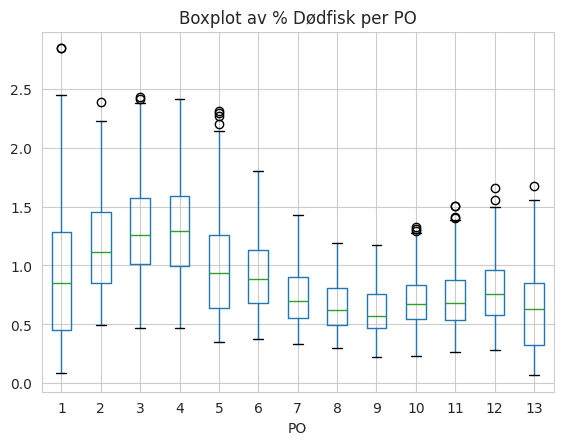

Før: 2054
Etter: 1958

Data lagret til /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/biostat_tot.csv


In [69]:
import numpy as np
import pandas as pd # Sørg for at pandas er importert

# --- Anta at df_biostat og df_biostat_po er klare ---
# ...

# --- Sørg for at Dato og PO er kolonner ---
if df_biostat_po.index.name == 'Dato':
    df_biostat_po.reset_index(inplace=True)
if 'PO' not in df_biostat_po.columns and df_biostat_po.index.name == 'PO': # Hvis PO også var indeks
     df_biostat_po.reset_index(inplace=True)

if df_biostat.index.name == 'Dato':
    df_biostat.reset_index(inplace=True)
if 'PO' not in df_biostat.columns and df_biostat.index.name == 'PO': # Hvis PO også var indeks
     df_biostat.reset_index(inplace=True)

# --- Nå kan du legge til suffiks og merge ---

# 1. Outer Merge med suffikser
df_merged_temp = pd.merge(
    df_biostat_po.add_suffix('_po'), # Legg til suffiks etter reset_index
    df_biostat.add_suffix('_orig'), # Legg til suffiks etter reset_index
    left_on=['Dato_po', 'PO_po'],
    right_on=['Dato_orig', 'PO_orig'],
    how='outer'
)

# Fyll Dato og PO fra den ene hvis den andre mangler
df_merged_temp['Dato'] = df_merged_temp['Dato_po'].combine_first(df_merged_temp['Dato_orig'])
df_merged_temp['PO'] = df_merged_temp['PO_po'].combine_first(df_merged_temp['PO_orig'])

# 2. Kombiner relevante kolonner - prioriter _orig (df_biostat)
cols_to_combine = ['BEHFISK_STK', 'BIOMASSE_KG', 'FORFORBRUK_KG', 'DØDFISK_STK'] # Juster ved behov

df_biostat_tot = pd.DataFrame({
    'Dato': df_merged_temp['Dato'],
    'PO': df_merged_temp['PO']
})

for col in cols_to_combine:
    col_orig = f"{col}_orig"
    col_po = f"{col}_po"
    if col_orig in df_merged_temp.columns and col_po in df_merged_temp.columns:
        df_biostat_tot[col] = df_merged_temp[col_orig].combine_first(df_merged_temp[col_po])
    elif col_orig in df_merged_temp.columns:
         df_biostat_tot[col] = df_merged_temp[col_orig]
    elif col_po in df_merged_temp.columns:
         df_biostat_tot[col] = df_merged_temp[col_po]

# 3. Rekalkuler rater/prosenter
if 'DØDFISK_STK' in df_biostat_tot.columns and 'BEHFISK_STK' in df_biostat_tot.columns:
    df_biostat_tot['% Dødfisk'] = (df_biostat_tot['DØDFISK_STK'] / df_biostat_tot['BEHFISK_STK'].replace(0, pd.NA) * 100).fillna(0)

if 'FORFORBRUK_KG' in df_biostat_tot.columns and 'BIOMASSE_KG' in df_biostat_tot.columns:
    df_biostat_tot['% FORFORBRUK'] = (df_biostat_tot['FORFORBRUK_KG'] / df_biostat_tot['BIOMASSE_KG'].replace(0, pd.NA) * 100).fillna(0)

# Rekalkuler Tetthet (krever po_areal_map definert)
if 'BIOMASSE_KG' in df_biostat_tot.columns and 'po_areal_map' in locals():
    df_biostat_tot['Areal_PO'] = df_biostat_tot['PO'].map(po_areal_map)
    df_biostat_tot['Tetthet'] = (df_biostat_tot['BIOMASSE_KG'] / df_biostat_tot['Areal_PO'].replace(0, pd.NA)).fillna(0)
    df_biostat_tot = df_biostat_tot.drop(columns=['Areal_PO'])

# 4. Sorter og vis
df_biostat_tot = df_biostat_tot.sort_values(by=['PO', 'Dato']).reset_index(drop=True)
df_biostat_tot.dropna(subset=['Dato', 'PO'], inplace=True) # Fjern helt tomme rader

print("Kombinert DataFrame (df_biostat_tot):")
print(df_biostat_tot.head())
print("\nSjekk slutten av datasettet for å se nyere data:")
print(df_biostat_tot.tail())




col = "% Dødfisk"

def remove_iqr_outliers(df, group_col, value_col):
    def iqr_filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower) & (group[value_col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

df_biostat_tot_iqr = remove_iqr_outliers(df_biostat_tot, "PO", col)


df_biostat_tot_iqr = df_biostat_tot_iqr[df_biostat_tot_iqr[col] < 30000]
df_biostat_tot_iqr = df_biostat_tot_iqr[df_biostat_tot_iqr[col] > 0]
plt.figure(figsize=(10,4))
df_biostat_tot_iqr.boxplot(column=col, by="PO")
plt.title(f"Boxplot av {col} per PO")
plt.suptitle("")
plt.show()
print("Før:", len(df_biostat_tot))
print("Etter:", len(df_biostat_tot_iqr))
df_biostat_tot = df_biostat_tot_iqr

# Lagre til CSV
output_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/biostat_tot.csv"
df_biostat_tot_iqr.to_csv(output_path, index=False, sep=';')
print(f"\nData lagret til {output_path}")

#printer starten av PO13





In [34]:
import pandas as pd
import numpy as np

# 1) Les inn rådata
file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/times_NK800_SSSarea_Scrit20_PO.asc"
column_names = [
    "Year", "Month", "Day"
] + [f"PO_{i}" for i in range(1, 14)]  # juster dersom du har flere/andre PO-kolonner

df_salt = pd.read_csv(
    file_path,
    sep=r"\s+",
    header=None,
    names=column_names,
    parse_dates=False
)

# 2) Bygg Dato-kolonne og sett som indeks
df_salt["Dato"] = pd.to_datetime(df_salt[["Year","Month","Day"]])
df_salt = df_salt.drop(columns=["Year","Month","Day"]).set_index("Dato")

# 3) Månedlig gjennomsnitt (i km²)
df_month = df_salt.resample("M").mean().round(2)

# 4) Smelt slik at hver PO blir en rad
df_month = (
    df_month
    .reset_index()
    .melt(id_vars="Dato", var_name="PO", value_name="BrakkvannsAreal_km2")
)

# 5) Rydd opp i PO-koden (fjern "PO_")
df_month["PO"] = df_month["PO"].str.replace("PO_", "").astype(float)

# 6) Beregn langtidsmiddel og standardavvik per PO
stats = (
    df_month
    .groupby("PO")["BrakkvannsAreal_km2"]
    .agg(BA_mean="mean", BA_std="std")
    .reset_index()
)

# 7) Slå sammen og regn ut anomaliene
df_anom = (
    df_month
    .merge(stats, on="PO", how="left")
    .assign(
        BA_ano = lambda d: (d["BrakkvannsAreal_km2"] - d["BA_mean"]) / d["BA_std"]
    )
    .drop(columns=["BA_mean","BA_std"])
)

# 8) Lagre resultatet
output_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/salt_tot_anom.csv"
df_anom.to_csv(output_path, sep=";", index=False)
print(f"Data med anomalier lagret til {output_path}")

df_salt = df_anom.copy()
df_salt.head(5)

Data med anomalier lagret til /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/salt_tot_anom.csv


,Dato,PO,BrakkvannsAreal_km2,BA_ano
0,2012-01-31,1.0,101.96,-0.907733
1,2012-02-29,1.0,132.93,-0.866786
2,2012-03-31,1.0,481.19,-0.406341
3,2012-04-30,1.0,306.47,-0.637344
4,2012-05-31,1.0,1606.42,1.081360


Index(['id', 'name', 'status', 'areal', 'sjoareal', 'sjoareal_g', 'globalid',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')
   ProduksjonsområdeId  Antall_påvisninger
0                  2.0                7588
1                  3.0               17090
2                  4.0               16137
3                  5.0                5657
4                  6.0               23707
[ 3.  4.  6. 12.  5.  9.  7.  8.  2. nan 10. 11.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
float64 float64


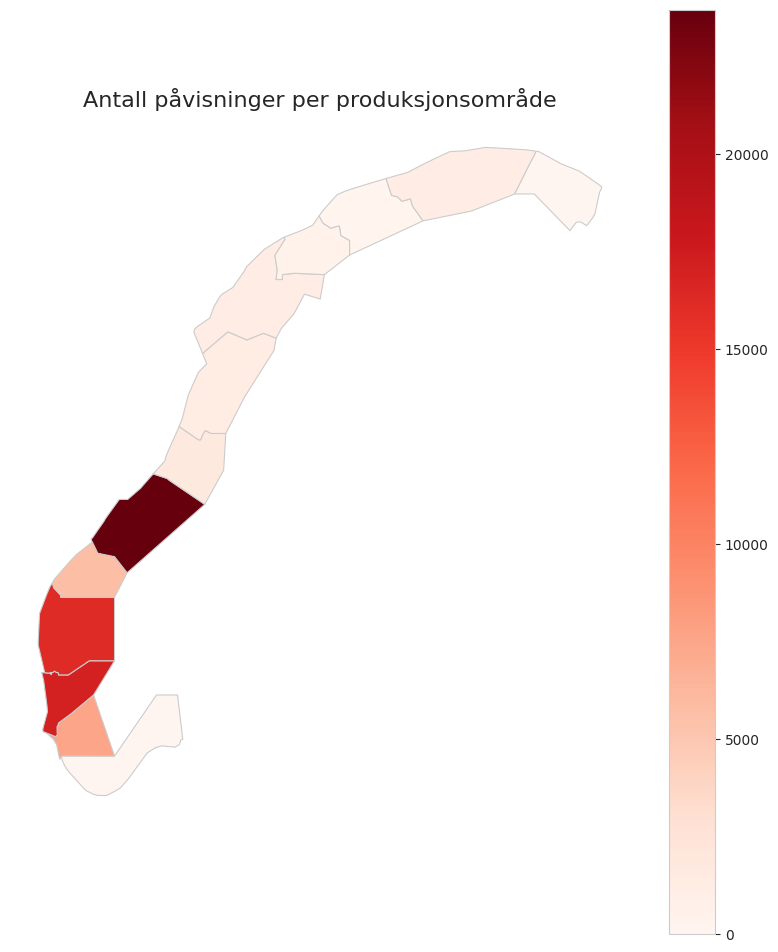

,Påvist-dato,Sykdom,Status,ProduksjonsområdeId,Produksjonsområde,Avsluttet-dato
0,NaT,PD,Påvist,3.0,Karmøy til Sotra,NaT
1,NaT,PD,Påvist,4.0,Nordhordaland til Stadt,NaT
2,NaT,PD,Påvist,6.0,Nordmøre og Sør-Trøndelag,NaT
3,NaT,PD,Påvist,4.0,Nordhordaland til Stadt,NaT
4,NaT,PD,Påvist,4.0,Nordhordaland til Stadt,NaT


In [11]:
file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/ila_pd.csv"

df_sykdom = pd.read_csv(file_path, sep=",", decimal=".", na_values=["(null)"], low_memory=False)

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Les sykdomsdata og shapefil
df_sykdom = pd.read_csv(file_path, sep=",", decimal=".", na_values=["(null)"], low_memory=False)
# ...eksisterende kode...

# Filtrer kun PD og ILA
df_sykdom = df_sykdom[df_sykdom['Sykdom'].isin(['PD', 'ILA'])]

# ...resten av koden...
gdf = gpd.read_file("/Users/eirikkloosterman/Documents/bachelor/Fiskeridir_Produksjonsområder_j203b0334351e4a12945318e0daaee45e/Fiskeridir_Produksjonsområder.shp")

# Tell antall påvisninger per produksjonsområde
antall_pavist = df_sykdom.groupby("ProduksjonsområdeId").size().reset_index(name="Antall_påvisninger")

# Sjekk at kolonnenavn matcher shapefilen
print(gdf.columns)
print(antall_pavist.head())

# Slå sammen med shapefilen (antatt at 'id' i shapefilen matcher 'ProduksjonsområdeId')
gdf_plot = gdf.merge(antall_pavist, left_on="id", right_on="ProduksjonsområdeId", how="left")

# Fyll NaN med 0 (områder uten påvisning)
gdf_plot["Antall_påvisninger"] = gdf_plot["Antall_påvisninger"].fillna(0)

# ...eksisterende kode...

# Sjekk datatyper og unike verdier
print(df_sykdom['ProduksjonsområdeId'].unique())
print(gdf['id'].unique())
print(df_sykdom['ProduksjonsområdeId'].dtype, gdf['id'].dtype)

# Sørg for at begge er strenger (eller begge int, hvis det passer)
df_sykdom['ProduksjonsområdeId'] = df_sykdom['ProduksjonsområdeId'].astype(str).str.strip()
gdf['id'] = gdf['id'].astype(str).str.strip()

# Tell antall påvisninger per produksjonsområde
antall_pavist = df_sykdom.groupby("ProduksjonsområdeId").size().reset_index(name="Antall_påvisninger")

# Slå sammen med shapefilen
gdf_plot = gdf.merge(antall_pavist, left_on="id", right_on="ProduksjonsområdeId", how="left")

# Fyll NaN med 0 (områder uten påvisning)
gdf_plot["Antall_påvisninger"] = gdf_plot["Antall_påvisninger"].fillna(0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_plot.plot(column="Antall_påvisninger", cmap="Reds", linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
ax.set_title("Antall påvisninger per produksjonsområde", fontsize=16)
ax.axis('off')
plt.show()

#kolonner i dataen: Uke	År	Lokalitetsnummer	Lokalitetsnavn	Sykdom	Status	Fra dato	Til dato	Kommunenummer	Kommune	...	Lat	Lon	ProduksjonsområdeId	Produksjonsområde	UtbruddsId	Subtype	Mistanke-dato	Påvist-dato	Tømt-dato	Avsluttet-dato

# Kolonnene som er relevante for oss er: Sykdom, Status, ProduksjonsområdeId, Påvist-dato, Avsluttet-dato
# Vi vil også fjerne de som ikke er relevante for oss
#fjerner kolonner
df_sykdom = df_sykdom.drop(columns=["Uke", "År", "Lokalitetsnummer", "Fylkesnummer", "Fylke", "Lokalitetsnavn", "Fra dato", "Til dato", "Kommunenummer", "Kommune", "Lat", "Lon", "UtbruddsId", "Subtype", "Mistanke-dato", "Tømt-dato"])


#gjør om til datetime
df_sykdom['Påvist-dato'] = pd.to_datetime(df_sykdom['Påvist-dato'], format='%Y.%m.%d', errors='coerce')
df_sykdom['Avsluttet-dato'] = pd.to_datetime(df_sykdom['Avsluttet-dato'], format='%Y.%m.%d', errors='coerce')
#setter dato som første kolonne
df_sykdom = df_sykdom[['Påvist-dato'] + [col for col in df_sykdom.columns if col != 'Påvist-dato']]
#gjør siste dag i måneden til dato
df_sykdom['Påvist-dato'] = df_sykdom['Påvist-dato'] + pd.offsets.MonthEnd(0)


df_sykdom.head()

In [12]:
import pandas as pd
import numpy as np

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/ila_pd.csv"
df_sykdom = pd.read_csv(file_path, sep=",", decimal=".", na_values=["(null)"], low_memory=False)

# Bruk "Fra dato" og "Til dato"
df_sykdom["Fra dato"] = pd.to_datetime(df_sykdom["Fra dato"], errors="coerce")
df_sykdom["Til dato"] = pd.to_datetime(df_sykdom["Til dato"], errors="coerce")

print(df_sykdom["Fra dato"].min())

def month_range(start, end):
    if pd.isna(end):
        end = pd.Timestamp.today()
    start = (start + pd.offsets.MonthEnd(0)).normalize()
    end = (end + pd.offsets.MonthEnd(0)).normalize()
    current = start
    while current <= end:
        yield current
        current += pd.offsets.MonthEnd(1)

rows = []

for idx, row in df_sykdom.iterrows():
    start_dt = row["Fra dato"]
    end_dt = row["Til dato"]
    sykdom = str(row["Sykdom"])
    po_id = row["ProduksjonsområdeId"]

    if pd.isna(start_dt):
        continue

    for month_end_date in month_range(start_dt, end_dt):
        rows.append({
            "ProduksjonsområdeId": po_id,
            "Dato": month_end_date,
            "Sykdom": sykdom,
            "Aktiv": 1
        })

df_active = pd.DataFrame(rows)

df_pivot = (
    df_active
    .groupby(["ProduksjonsområdeId", "Dato", "Sykdom"])["Aktiv"]
    .max()
    .unstack(fill_value=0)
    .reset_index()
)
df_pivot.rename(
    columns={"SYSTEMISK_INFEKSJON_MED_FLAVOBACTERIUM_PSYCHROPHILUM": "SIMFP"},
    inplace=True
)

#renamer ProductionsområdeId til PO
df_pivot.rename(columns={"ProduksjonsområdeId": "PO"}, inplace=True)

#setter dato som indeks
df_pivot.set_index("Dato", inplace=True)

print(df_sykdom.groupby("ProduksjonsområdeId").size().reset_index(name="antall_rader"))

#lagre til csv
output_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/sykdom_tot.csv"
df_pivot.to_csv(output_path, index=False, sep=';')
print(f"\nData lagret til {output_path}")


df_pivot.tail(10)


2010-07-07 00:00:00
    ProduksjonsområdeId  antall_rader
0                   2.0          7588
1                   3.0         17099
2                   4.0         16330
3                   5.0          5657
4                   6.0         23736
5                   7.0          1758
6                   8.0          1353
7                   9.0          1257
8                  10.0           553
9                  11.0           238
10                 12.0          1116

Data lagret til /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/sykdom_tot.csv


Sykdom,PO,BKD,ILA,PD,SIMFP
Dato,,,,,
2024-08-31,12.0,0,1,0,0
2024-09-30,12.0,0,1,0,0
2024-10-31,12.0,0,1,0,0
2024-11-30,12.0,0,1,0,0
2024-12-31,12.0,0,1,0,0
2025-01-31,12.0,0,1,0,0
2025-02-28,12.0,0,1,0,0
2025-03-31,12.0,0,1,0,0
2025-04-30,12.0,0,1,0,0


In [13]:
import pandas as pd
import numpy as np

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/ila_pd.csv"
df_sykdom = pd.read_csv(file_path, sep=",", decimal=".", na_values=["(null)"], low_memory=False)

# Bruk "Fra dato" og "Til dato"
df_sykdom["Fra dato"] = pd.to_datetime(df_sykdom["Fra dato"], errors="coerce")
df_sykdom["Til dato"] = pd.to_datetime(df_sykdom["Til dato"], errors="coerce")

def month_range(start, end):
    if pd.isna(end):
        end = pd.Timestamp.today()
    start = (start + pd.offsets.MonthEnd(0)).normalize()
    end = (end + pd.offsets.MonthEnd(0)).normalize()
    current = start
    while current <= end:
        yield current
        current += pd.offsets.MonthEnd(1)

rows = []

for idx, row in df_sykdom.iterrows():
    start_dt = row["Fra dato"]
    end_dt = row["Til dato"]
    sykdom = str(row["Sykdom"])
    po_id = row["ProduksjonsområdeId"]

    if pd.isna(start_dt) or pd.isna(po_id) or pd.isna(sykdom):
        continue

    for month_end_date in month_range(start_dt, end_dt):
        rows.append({
            "ProduksjonsområdeId": po_id,
            "Dato": month_end_date,
            "Sykdom": sykdom,
            "Aktiv": 1
        })

df_active = pd.DataFrame(rows)

# Nå bruker vi sum for å telle antall samtidige aktive utbrudd
df_pivot = (
    df_active
    .groupby(["ProduksjonsområdeId", "Dato", "Sykdom"])["Aktiv"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)
df_pivot.rename(
    columns={"SYSTEMISK_INFEKSJON_MED_FLAVOBACTERIUM_PSYCHROPHILUM": "SIMFP"},
    inplace=True
)

# Renamer ProductionsområdeId til PO
df_pivot.rename(columns={"ProduksjonsområdeId": "PO"}, inplace=True)

# Setter dato som indeks
df_pivot.set_index("Dato", inplace=True)


df_pivot.tail(10)

Sykdom,PO,BKD,ILA,PD,SIMFP
Dato,,,,,
2024-08-31,12.0,0,48,0,0
2024-09-30,12.0,0,48,0,0
2024-10-31,12.0,0,48,0,0
2024-11-30,12.0,0,48,0,0
2024-12-31,12.0,0,48,0,0
2025-01-31,12.0,0,48,0,0
2025-02-28,12.0,0,66,0,0
2025-03-31,12.0,0,66,0,0
2025-04-30,12.0,0,66,0,0


In [14]:
import pandas as pd

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/tiltak_mot_lakselus.csv"

# Les inn data
df_lus = pd.read_csv(file_path, sep=",", decimal=".", na_values=["(null)"], low_memory=False)

# Lag en dato-kolonne basert på År og Uke (bruk mandag i hver uke)
df_lus["Dato"] = pd.to_datetime(df_lus["År"].astype(str) + df_lus["Uke"].astype(str) + '1', format='%G%V%u', errors='coerce')
# Sett dato til månedsslutt
df_lus["Dato"] = df_lus["Dato"] + pd.offsets.MonthEnd(0)

# Tell antall behandlinger per produksjonsområde per måned og behandlingstype
df_lus["Antall behandlinger"] = 1
df_lus_grouped = (
    df_lus.groupby(["ProduksjonsområdeId", "Dato", "Type behandling"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

print(df_lus_grouped)

Type behandling  ProduksjonsområdeId       Dato  annen behandling  \
0                                1.0 2016-09-30                 0   
1                                1.0 2016-10-31                 0   
2                                1.0 2018-04-30                 0   
3                                1.0 2018-05-31                 0   
4                                1.0 2019-01-31                 0   
...                              ...        ...               ...   
1571                            13.0 2023-09-30                 0   
1572                            13.0 2023-10-31                 0   
1573                            13.0 2024-09-30                 3   
1574                            13.0 2024-10-31                 0   
1575                            13.0 2024-11-30                 0   

Type behandling  badebehandling  ferskvannsbehandling  fôrbehandling  \
0                             4                     0              0   
1                          

In [15]:
import pandas as pd

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/tiltak_mot_lakselus.csv"

df_lus = pd.read_csv(file_path, sep=",", decimal=".", na_values=["(null)"], low_memory=False)

# Lag en dato-kolonne basert på År og Uke (bruk mandag i hver uke)
df_lus["Dato"] = pd.to_datetime(df_lus["År"].astype(str) + df_lus["Uke"].astype(str) + '1', format='%G%V%u', errors='coerce')
df_lus["Dato"] = df_lus["Dato"] + pd.offsets.MonthEnd(0)

# Filtrer til tiltak "rensefisk"
df_rensefisk = df_lus[df_lus["Tiltak"].str.lower() == "rensefisk"].copy()

# Summer antall rensefisk per produksjonsområde og måned
df_rensefisk_grouped = (
    df_rensefisk.groupby(["ProduksjonsområdeId", "Dato"])["Antall"]
    .sum()
    .reset_index()
    .rename(columns={"Antall": "Antall_rensefisk"})
)


print(df_rensefisk_grouped.head(20))

    ProduksjonsområdeId       Dato  Antall_rensefisk
0                   1.0 2012-06-30            2557.0
1                   1.0 2012-07-31           63520.0
2                   1.0 2012-08-31           17653.0
3                   1.0 2012-09-30           11247.0
4                   1.0 2012-10-31           38130.0
5                   1.0 2012-11-30           44955.0
6                   1.0 2013-03-31            5150.0
7                   1.0 2013-06-30            2751.0
8                   1.0 2013-07-31           22206.0
9                   1.0 2013-08-31           30338.0
10                  1.0 2013-09-30          104835.0
11                  1.0 2013-10-31           17704.0
12                  1.0 2013-11-30            7289.0
13                  1.0 2014-06-30            2635.0
14                  1.0 2014-07-31           45307.0
15                  1.0 2014-08-31           78591.0
16                  1.0 2014-09-30           78299.0
17                  1.0 2014-10-31           2

In [16]:
# Antar at df_lus_grouped allerede er laget slik:
# df_lus_grouped = (
#     df_lus.groupby(["ProduksjonsområdeId", "Dato", "Type behandling"])
#     .size()
#     .unstack(fill_value=0)
#     .reset_index()
# )

# Merge på ProduksjonsområdeId og Dato
df_lus_merged = pd.merge(
    df_lus_grouped,
    df_rensefisk_grouped,
    on=["ProduksjonsområdeId", "Dato"],
    how="left"
)

# Fyll NaN i Antall_rensefisk med 0 (dersom ingen rensefisk brukt den måneden)
df_lus_merged["Antall_rensefisk"] = df_lus_merged["Antall_rensefisk"].fillna(0).astype(int)

# Finn alle kolonner for behandlingstyper (unntatt 'ProduksjonsområdeId', 'Dato', 'Antall_rensefisk')
behandling_cols = [col for col in df_lus_merged.columns if col not in ["ProduksjonsområdeId", "Dato", "Antall_rensefisk"]]

# Gjør om til binær (1 hvis >0, ellers 0)
df_lus_merged[behandling_cols] = (df_lus_merged[behandling_cols] > 0).astype(int)

# gjør om til datetime
df_lus_merged['Dato'] = pd.to_datetime(df_lus_merged['Dato'], format='%Y-%m-%d', errors='coerce')
# Sorter etter ProduksjonsområdeId og Dato
df_lus_merged = df_lus_merged.sort_values(by=["ProduksjonsområdeId", "Dato"])

#renamer ProductionsområdeId til PO
df_lus_merged.rename(columns={"ProduksjonsområdeId": "PO"}, inplace=True)

df_lus_merged.set_index("Dato", inplace=True)

import pandas as pd

# Finn alle unike PO
alle_po = df_lus_merged["PO"].unique()

# Finn min og maks dato
min_dato = pd.to_datetime("2012-01-31")  # eller bruk df_lus_merged.index.min() hvis du vil være dynamisk
max_dato = df_lus_merged.index.max()

# Lag en komplett MultiIndex med alle PO og alle måneder fra 2012 til siste måned
alle_datoer = pd.date_range(min_dato, max_dato, freq="M")
full_index = pd.MultiIndex.from_product([alle_po, alle_datoer], names=["PO", "Dato"])

# Reindekser df_lus_merged til denne fullstendige indeksen
df_lus_merged_reset = df_lus_merged.reset_index()
df_lus_merged_full = df_lus_merged_reset.set_index(["PO", "Dato"]).reindex(full_index).reset_index()

# Fyll inn 0 for alle behandlingstyper der det mangler data (men behold antall rensefisk)
for col in behandling_cols:
    df_lus_merged_full[col] = df_lus_merged_full[col].fillna(0).astype(int)
df_lus_merged_full["Antall_rensefisk"] = df_lus_merged_full["Antall_rensefisk"].fillna(0).astype(int)

# Sett Dato som indeks igjen hvis ønskelig
df_lus_merged_full.set_index("Dato", inplace=True)

print(df_lus_merged_full.head(20))




print(df_lus_merged.head(20))

             PO  annen behandling  badebehandling  ferskvannsbehandling  \
Dato                                                                      
2012-01-31  1.0                 0               0                     0   
2012-02-29  1.0                 0               0                     0   
2012-03-31  1.0                 0               0                     0   
2012-04-30  1.0                 0               0                     0   
2012-05-31  1.0                 0               0                     0   
2012-06-30  1.0                 0               0                     0   
2012-07-31  1.0                 0               0                     0   
2012-08-31  1.0                 0               0                     0   
2012-09-30  1.0                 0               0                     0   
2012-10-31  1.0                 0               0                     0   
2012-11-30  1.0                 0               0                     0   
2012-12-31  1.0          

In [17]:
# leser filen Rensefisk_2019_2025.xlsx

file_path = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/raw/Rensefisk_2019_2025.xlsx"
df_rensefisk = pd.read_excel(file_path, sheet_name="Sheet1", skiprows=2)

# Kolonnene i dataen: Måned,Produksjonsområde, *Dødelighet (antall), Utsatt (antall)
#konverterer til datetime
df_rensefisk['Dato'] = pd.to_datetime(df_rensefisk['Måned'], format='%Y-%m', errors='coerce')
df_rensefisk['Dato'] = df_rensefisk['Dato'] + pd.offsets.MonthEnd(0)

# Ekstraherer tallet først i "Produksjonsområde" og konverterer til int
df_rensefisk["PO"] = df_rensefisk["Produksjonsområde"].str.extract(r"^(\d+)").astype(float)

# Fjerner unødvendige kolonner
df_rensefisk = df_rensefisk.drop(columns=["Måned", "Produksjonsområde"])

# setter dato som første kolonne
df_rensefisk = df_rensefisk.sort_values(by=["PO", "Dato"])
df_rensefisk = df_rensefisk[['PO'] + [col for col in df_rensefisk.columns if col != 'PO']]

df_rensefisk.set_index("Dato", inplace=True)

# Fjerner rader med NaN i PO
df_rensefisk = df_rensefisk.dropna(subset=["PO"])

df_rensefisk.head(10)
df_rensefisk.tail(10)

,PO,*Dødelighet (antall),Utsatt (antall)
Dato,,,
2023-05-31,13.0,55,108492
2023-06-30,13.0,675,104306
2023-07-31,13.0,2840,46928
2023-08-31,13.0,69256,0
2023-09-30,13.0,104523,0
2023-10-31,13.0,55713,0
2023-11-30,13.0,9881,0
2023-12-31,13.0,1727,0
2024-01-31,13.0,1173,0


In [18]:
import pandas as pd # Ensure pandas is imported

# Sørg for at df_rensefisk har riktig kolonnenavn for utsatt rensefisk og dødelighet
# Reset index på df_rensefisk FØR du velger kolonner, slik at Dato blir en kolonne
df_rensefisk_reset = df_rensefisk.reset_index()

# Velg kolonner inkludert Dødelighet
cols_from_rensefisk = ["PO", "Dato", "Utsatt (antall)", "*Dødelighet (antall)"]
# Sjekk om kolonnen finnes før du inkluderer den
if "*Dødelighet (antall)" not in df_rensefisk_reset.columns:
    print("Advarsel: Kolonnen '*Dødelighet (antall)' finnes ikke i df_rensefisk_reset.")
    cols_from_rensefisk.remove("*Dødelighet (antall)")

# Sjekk om alle valgte kolonner faktisk finnes
missing_cols = [col for col in cols_from_rensefisk if col not in df_rensefisk_reset.columns]
if missing_cols:
    raise KeyError(f"Følgende kolonner mangler i df_rensefisk_reset: {missing_cols}")

df_rensefisk_subset = df_rensefisk_reset[cols_from_rensefisk].copy()

# Gi kolonnene nye navn
rename_dict = {"Utsatt (antall)": "Antall_rensefisk_utsatt"}
if "*Dødelighet (antall)" in df_rensefisk_subset.columns:
    rename_dict["*Dødelighet (antall)"] = "Dødelighet_rensefisk" # Nytt navn

df_rensefisk_subset = df_rensefisk_subset.rename(columns=rename_dict)

# Konverter Dødelighet_rensefisk til numerisk type, behold NaN der det ikke går
if "Dødelighet_rensefisk" in df_rensefisk_subset.columns:
    df_rensefisk_subset["Dødelighet_rensefisk"] = pd.to_numeric(df_rensefisk_subset["Dødelighet_rensefisk"], errors='coerce')


# Sørg for at df_lus_merged_full også har Dato som kolonne
if df_lus_merged_full.index.name == 'Dato':
    df_lus_merged_full = df_lus_merged_full.reset_index()

# Merge på PO og Dato
df_total_rensefisk = pd.merge(
    df_lus_merged_full,
    df_rensefisk_subset, # Bruk den nye subset-dataframen
    how="left",
    on=["PO", "Dato"]
)

# Fyll NaN med 0 KUN for Antall_rensefisk_utsatt (for totalberegning)
df_total_rensefisk["Antall_rensefisk_utsatt"] = df_total_rensefisk["Antall_rensefisk_utsatt"].fillna(0).astype(int)
# IKKE fyll NaN for Dødelighet_rensefisk

# Kombiner kolonnene til én "Antall_rensefisk_total"
df_total_rensefisk["Antall_rensefisk_total"] = (
    df_total_rensefisk.get("Antall_rensefisk", pd.Series(0, index=df_total_rensefisk.index)).fillna(0) +
    df_total_rensefisk["Antall_rensefisk_utsatt"]
)

# Drop gamle rensefisk-kolonner og eventuelle hjelpeindekser
# Behold Dødelighet_rensefisk
columns_to_drop = ["Antall_rensefisk", "Antall_rensefisk_utsatt", "level_0", "index"]
df_total_rensefisk = df_total_rensefisk.drop(columns=[col for col in columns_to_drop if col in df_total_rensefisk.columns], errors='ignore')


# Sett Dato som indeks igjen hvis ønskelig (eller behold som kolonne)
# df_total_rensefisk.set_index("Dato", inplace=True)


print(df_total_rensefisk.head(10))
df_total_rensefisk.tail(10)

# For å verifisere: Sjekk en rad etter 2019 hvor du ser NaN, men forventet 0
# Finn en slik rad manuelt eller programmatisk, f.eks.:
# specific_date = '2019-05-31'
# specific_po = 3
# print("\nSjekk spesifikk rad der du ser NaN etter 2019:")
# print(df_total_rensefisk[(df_total_rensefisk['Dato'] == specific_date) & (df_total_rensefisk['PO'] == specific_po)])
# Gå deretter tilbake til den originale df_rensefisk og sjekk verdien for '*Dødelighet (antall)' for samme dato/PO.

        Dato   PO  annen behandling  badebehandling  ferskvannsbehandling  \
0 2012-01-31  1.0                 0               0                     0   
1 2012-02-29  1.0                 0               0                     0   
2 2012-03-31  1.0                 0               0                     0   
3 2012-04-30  1.0                 0               0                     0   
4 2012-05-31  1.0                 0               0                     0   
5 2012-06-30  1.0                 0               0                     0   
6 2012-07-31  1.0                 0               0                     0   
7 2012-08-31  1.0                 0               0                     0   
8 2012-09-30  1.0                 0               0                     0   
9 2012-10-31  1.0                 0               0                     0   

   fôrbehandling  mekanisk behandling  termisk behandling  \
0              0                    0                   0   
1              0              

,Dato,PO,annen behandling,badebehandling,ferskvannsbehandling,fôrbehandling,mekanisk behandling,termisk behandling,Dødelighet_rensefisk,Antall_rensefisk_total
2070,2024-07-31,13.0,0,0,0,0,0,0,NaN,0
2071,2024-08-31,13.0,0,0,0,0,0,0,NaN,0
2072,2024-09-30,13.0,1,1,0,0,0,0,NaN,0
2073,2024-10-31,13.0,0,0,0,0,1,0,NaN,0
2074,2024-11-30,13.0,0,1,0,0,0,0,NaN,0
2075,2024-12-31,13.0,0,0,0,0,0,0,NaN,0
2076,2025-01-31,13.0,0,0,0,0,0,0,NaN,0
2077,2025-02-28,13.0,0,0,0,0,0,0,NaN,0
2078,2025-03-31,13.0,0,0,0,0,0,0,NaN,0
2079,2025-04-30,13.0,0,0,0,0,0,0,NaN,0


In [70]:
# Sørg for at "Dato" og "PO" er kolonner i alle dataframes
from functools import reduce
for df in [df_biostat_tot, df_salt, df_temp, df_pivot, df_total_rensefisk]:
    if df.index.name == "Dato":
        df.reset_index(inplace=True)
    # Hvis PO også er indeks (uvanlig), gjør det samme:
    if df.index.name == "PO":
        df.reset_index(inplace=True)

# Nå kan du merge som før
dfs = [df_biostat_tot, df_salt, df_temp, df_pivot, df_total_rensefisk]
df_total = reduce(
    lambda left, right: pd.merge(left, right, on=["Dato", "PO"], how="outer"),
    dfs
)

df_total.sort_values(["PO", "Dato"], inplace=True)
# gjør om antall rensefisk total til % i det produksjonsområdet ved å ta antall_rensefisk_total / behfisk_stk
df_total["% Rensefisk"] = df_total["Antall_rensefisk_total"] / df_total["BEHFISK_STK"] * 100
# ...eksisterende kode...

# Gjør om Tetthet fra kg/km² til tonn/km²
if "Tetthet" in df_total.columns:
    df_total["Tetthet"] = df_total["Tetthet"] / 1000

# ...eksisterende kode...
df_total.head()

,Dato,PO,BEHFISK_STK,BIOMASSE_KG,FORFORBRUK_KG,DØDFISK_STK,% Dødfisk,% FORFORBRUK,Tetthet,BrakkvannsAreal_km2,...,SIMFP,annen behandling,badebehandling,ferskvannsbehandling,fôrbehandling,mekanisk behandling,termisk behandling,Dødelighet_rensefisk,Antall_rensefisk_total,% Rensefisk
0,2012-01-31,1.0,12612103.6,24749310.32,3767059.6,72884.0,0.577889,15.220867,5.382625,101.96,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
1,2012-02-29,1.0,11659039.2,23071582.60,2797140.8,81142.4,0.695961,12.123749,5.017743,132.93,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2,2012-03-31,1.0,10871338.0,20850721.60,2946169.2,89078.8,0.819391,14.129819,4.534737,481.19,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,2012-04-30,1.0,11542926.4,17931829.40,2600076.0,88236.8,0.764423,14.499781,3.899919,306.47,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,2012-05-31,1.0,11057955.2,17248389.80,2846917.2,114782.4,1.038007,16.505409,3.751281,1606.42,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


<Figure size 1000x400 with 0 Axes>

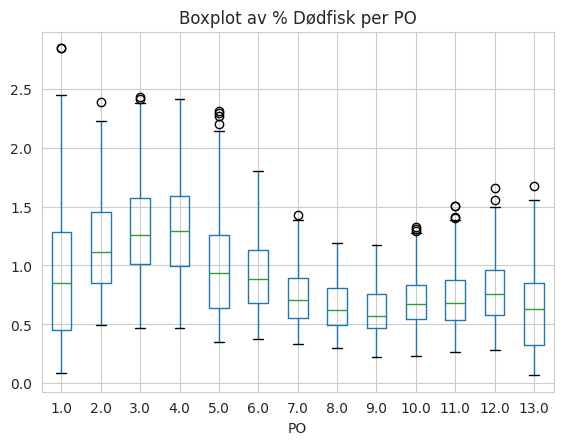

In [36]:
#boksplot av % Rensefisk per PO totalt
plt.figure(figsize=(10,4))
df_total.boxplot(column=col, by="PO")
plt.title(f"Boxplot av {col} per PO")
plt.suptitle("")
plt.show()

In [37]:
for name, df in zip(
    ["df_biostat_tot", "df_salt", "df_temp", "df_pivot", "df_total_rensefisk"],
    [df_biostat, df_salt, df_temp, df_pivot, df_total_rensefisk]
):
    print(f"{name}: {df.columns}")

df_biostat_tot: Index(['Dato', 'PO', 'BEHFISK_STK', 'BIOMASSE_KG', 'FORFORBRUK_KG',
       'DØDFISK_STK', '% Dødfisk', 'Tetthet', '% FORFORBRUK'],
      dtype='object')
df_salt: Index(['Dato', 'PO', 'BrakkvannsAreal_km2', 'BA_ano'], dtype='object')
df_temp: Index(['Dato', 'PO', 'Temperature'], dtype='object')
df_pivot: Index(['Dato', 'PO', 'BKD', 'ILA', 'PD', 'SIMFP'], dtype='object', name='Sykdom')
df_total_rensefisk: Index(['Dato', 'PO', 'annen behandling', 'badebehandling',
       'ferskvannsbehandling', 'fôrbehandling', 'mekanisk behandling',
       'termisk behandling', 'Dødelighet_rensefisk', 'Antall_rensefisk_total'],
      dtype='object')


In [22]:
df_total.describe(include='all')

,Dato,PO,BEHFISK_STK,BIOMASSE_KG,FORFORBRUK_KG,DØDFISK_STK,% Dødfisk,% FORFORBRUK,BrakkvannsAreal_km2,BA_ano,...,SIMFP,annen behandling,badebehandling,ferskvannsbehandling,fôrbehandling,mekanisk behandling,termisk behandling,Dødelighet_rensefisk,Antall_rensefisk_total,% Rensefisk
count,2141,2141.000000,1.958000e+03,1.958000e+03,1.958000e+03,1.958000e+03,1958.000000,1958.000000,1976.000000,1.976000e+03,...,1345.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,9.180000e+02,2.080000e+03,1958.000000
mean,2018-07-16 14:23:35.787015424,7.082672,3.126389e+07,5.697896e+07,1.091551e+07,2.844049e+05,0.890235,18.877488,293.489691,1.797932e-17,...,2.186617,0.060577,0.599519,0.054327,0.539904,0.059135,0.063942,1.921448e+05,1.817296e+05,0.537635
min,2010-07-31 00:00:00,1.000000,5.597630e+05,6.811826e+05,1.087500e+05,5.340000e+02,0.067873,6.690516,0.000000,-1.680371e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,2015-02-28 00:00:00,4.000000,1.938791e+07,3.470231e+07,5.387739e+06,1.337472e+05,0.570680,13.826401,15.492500,-6.521317e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.953075e+04,0.000000e+00,0.000000
50%,2018-07-31 00:00:00,7.000000,3.083144e+07,5.466438e+07,9.668114e+06,2.344995e+05,0.797818,18.294427,114.190000,-4.070862e-01,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,7.946600e+04,2.557600e+04,0.093966
75%,2021-12-31 00:00:00,10.000000,4.230772e+07,7.641085e+07,1.517511e+07,3.786735e+05,1.125628,24.046119,326.735000,4.172631e-01,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.601945e+05,1.942822e+05,0.676249
max,2025-05-31 00:00:00,13.000000,8.107868e+07,1.588869e+08,4.028856e+07,1.417667e+06,2.844555,34.976047,4120.030000,5.718593e+00,...,184.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.541973e+06,3.449792e+06,7.715802
std,NaN,3.739182,1.670026e+07,3.142109e+07,7.215425e+06,2.101057e+05,0.431703,5.809302,480.064014,9.969574e-01,...,19.104314,0.238610,0.490114,0.226716,0.498525,0.235933,0.244709,2.704721e+05,3.734604e+05,0.975565


<Axes: title={'center': 'Gj.snitt % rensefisk per produksjonsområde'}, xlabel='PO'>

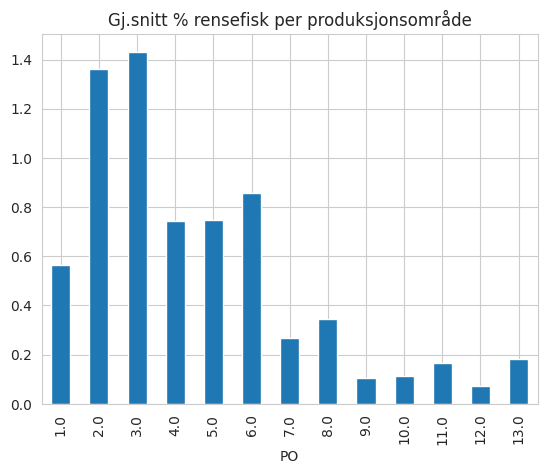

In [23]:
df_total.groupby("PO")["% Rensefisk"].mean().plot(kind="bar", title="Gj.snitt % rensefisk per produksjonsområde")

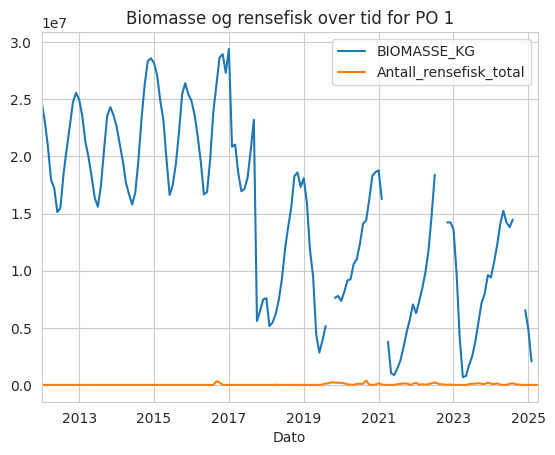

In [24]:
import matplotlib.pyplot as plt

po = 1  # velg produksjonsområde
df_total[df_total["PO"] == po][["Dato", "BIOMASSE_KG", "Antall_rensefisk_total"]].set_index("Dato").plot()
plt.title(f"Biomasse og rensefisk over tid for PO {po}")
plt.show()

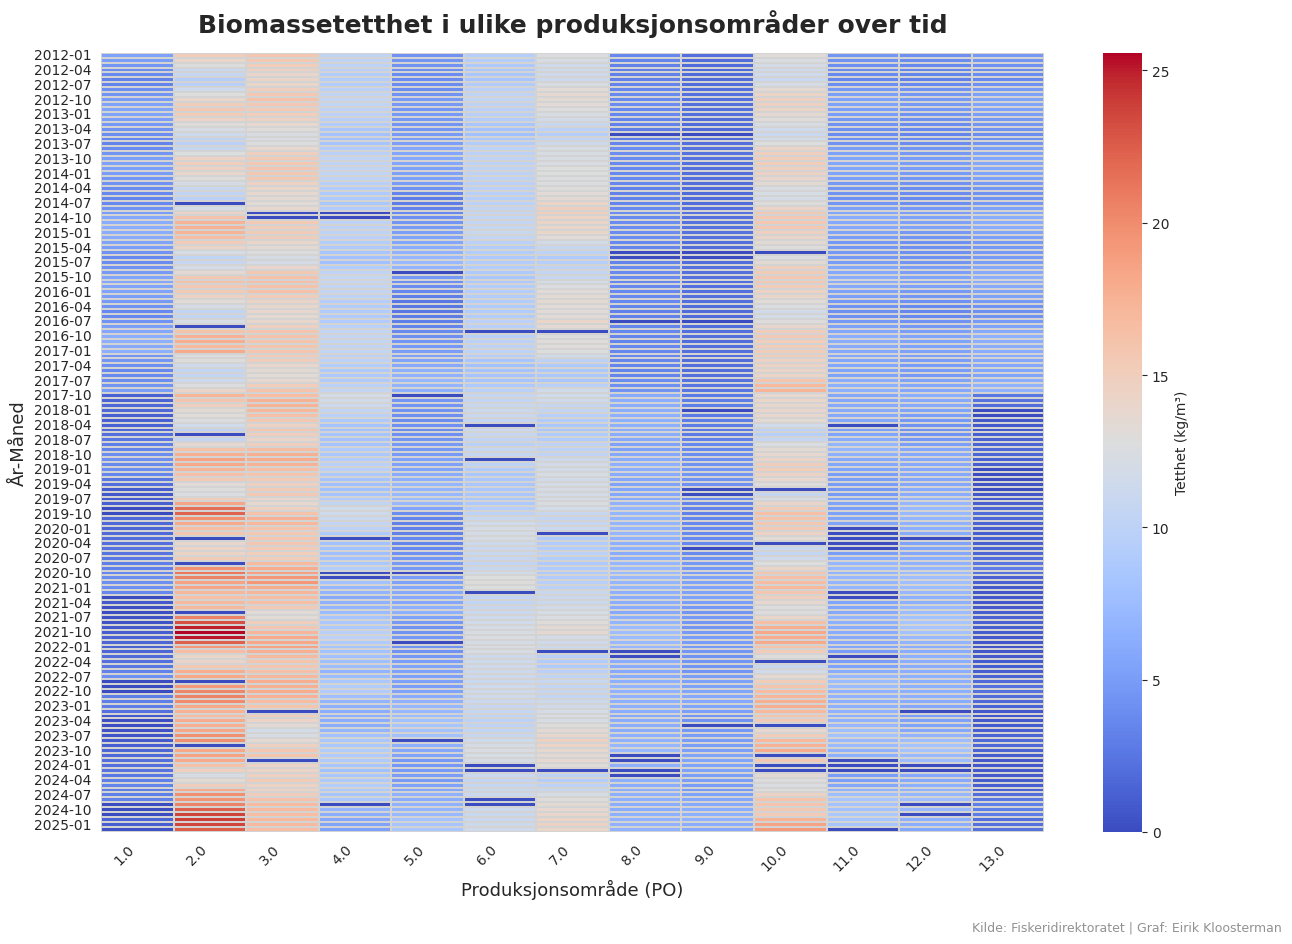

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Stilinnstillinger
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Lato", "DejaVu Sans", "Arial"]

# Lag ÅrMnd-kolonne
df_total['ÅrMnd'] = df_total['Dato'].dt.to_period('M').astype(str)

# Pivotér data
heatmap_data = df_total.pivot_table(
    index="ÅrMnd",
    columns="PO",
    values="Tetthet",
    fill_value=0
)

# Lag heatmap
plt.figure(figsize=(13, 10))
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",  # Alternativ: "RdBu_r", "RdYlBu"
    linewidths=0.3,
    linecolor='lightgrey',
    cbar_kws={'label': 'Tetthet (kg/m³)'},
    square=False
)

# Tittel og akser
ax.set_title("Biomassetetthet i ulike produksjonsområder over tid", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Produksjonsområde (PO)", fontsize=13)
ax.set_ylabel("År-Måned", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Kildetekst
plt.figtext(
    0.99, 0.01,
    "Kilde: Fiskeridirektoratet | Graf: Eirik Kloosterman",
    ha="right",
    va="bottom",
    fontsize=9,
    alpha=0.5
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


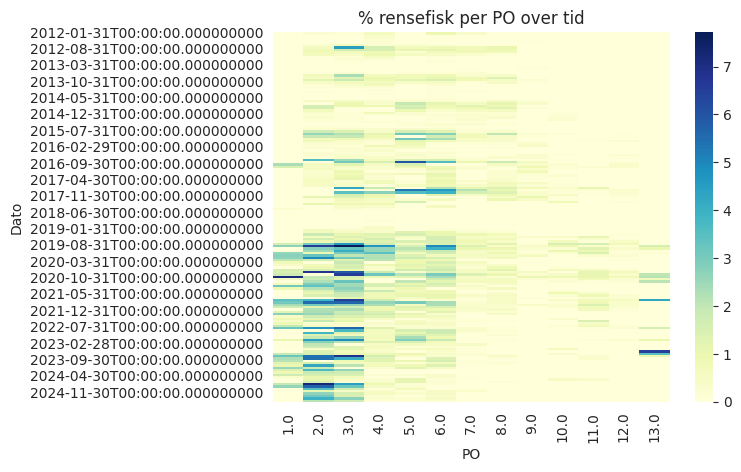

In [72]:
heatmap_data = df_total.pivot_table(index="Dato", columns="PO", values="% Rensefisk", fill_value=0)
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("% rensefisk per PO over tid")
plt.show()

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


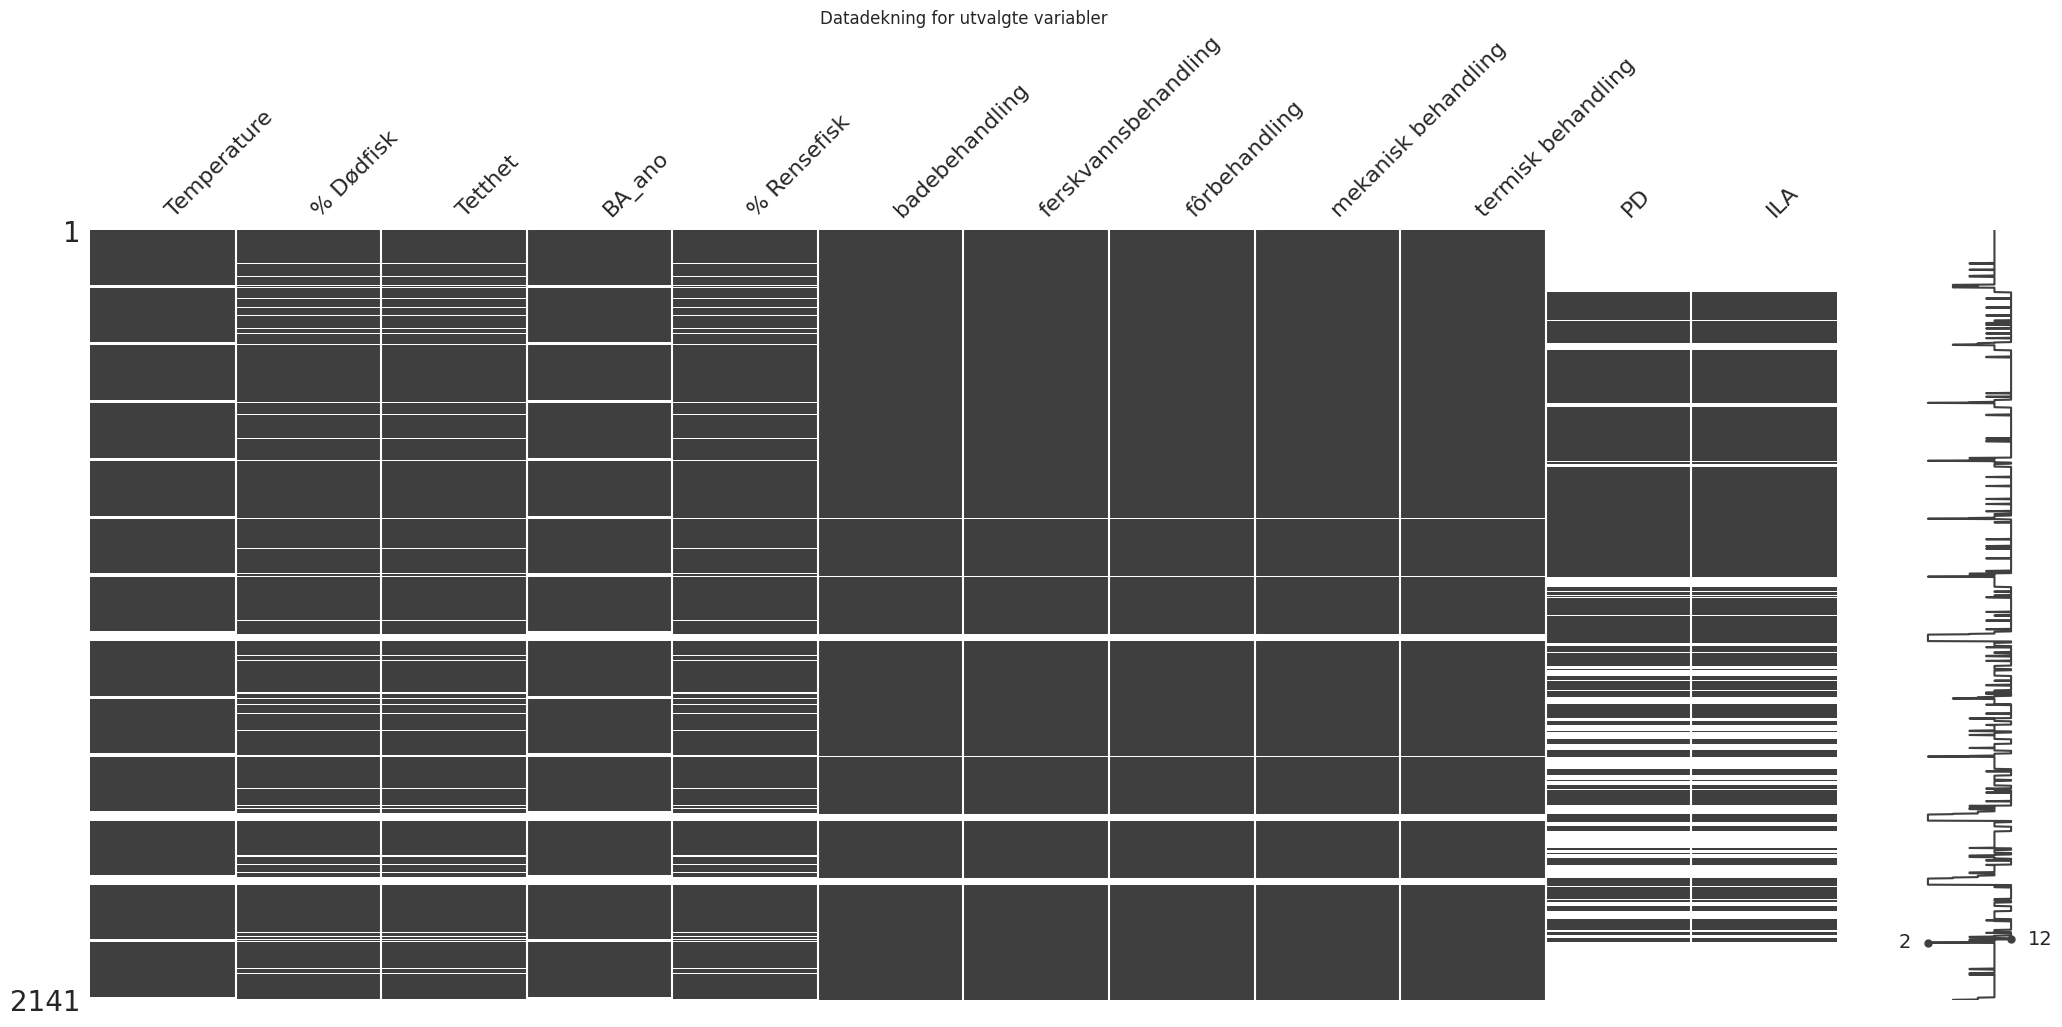

In [73]:
%pip install missingno

#framstilling av dataen våres, svart vise der vi har data og hvit der vi ikke har data
# hvit betyr ikke 0, bare at vi ikke har data. altså ubrukelig
#setter årstall som index

import missingno as msno

wanted_cols = [
    "Temperature", "% Dødfisk", "% Forforbruk", "Tetthet", "BA_ano",
    "% Rensefisk", "badebehandling", "ferskvannsbehandling",
    "fôrbehandling", "mekanisk behandling", "termisk behandling", "PD", "ILA",
]

# Filtrer til kun de kolonnene som faktisk finnes i datasettet
cols = [col for col in wanted_cols if col in df_total.columns]

# Sett Dato og PO som MultiIndex hvis ønskelig
df_total_indexed = df_total.set_index(['Dato', 'PO'])

# Visualiser kun de ønskede kolonnene
msno.matrix(df_total_indexed[cols])
plt.title("Datadekning for utvalgte variabler")
plt.show()


In [74]:
import os


output_file  = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data.csv"
output_excel = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data.xlsx"

# Lag katalogen hvis den ikke finnes
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Skriv til CSV og Excel
df_total.to_csv(output_file, index=False)
df_total.to_excel(output_excel, index=False)

print(f"CSV lagret til:   {output_file}")
print(f"Excel lagret til: {output_excel}")

CSV lagret til:   /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data.csv
Excel lagret til: /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data.xlsx


In [75]:
import os
import pandas as pd
import numpy as np

# 1. Sørg for at Dato er datetime
df_total['Dato'] = pd.to_datetime(df_total['Dato'])
df_biostat_iqr['Dato'] = pd.to_datetime(df_biostat_iqr['Dato'])

# 2. Filtrer til kun data fra og med 2017-10-31
df_filtered = df_total[df_total['Dato'] >= '2017-10-31'].copy()

# 3. Rekalibrer BA_ano for perioden fra 2017
if "BrakkvannsAreal_km2" in df_filtered.columns and "PO" in df_filtered.columns:
    stats_2017 = (
        df_filtered.groupby("PO")["BrakkvannsAreal_km2"]
        .agg(BA_mean="mean", BA_std="std")
        .reset_index()
    )
    df_filtered = df_filtered.merge(stats_2017, on="PO", how="left")
    df_filtered["BA_ano"] = (df_filtered["BrakkvannsAreal_km2"] - df_filtered["BA_mean"]) / df_filtered["BA_std"]
    df_filtered = df_filtered.drop(columns=["BA_mean", "BA_std"])

# 4. Bruk eksisterende df_biostat_iqr og erstatt % Dødfisk
# Filtrer df_biostat_iqr til samme periode og relevante kolonner
df_biostat_sub = df_biostat_iqr[df_biostat_iqr['Dato'] >= '2017-10-31'][['Dato', 'PO', '% Dødfisk']].copy()

# Dropp gammel % Dødfisk og legg inn ny fra df_biostat_iqr
df_filtered = df_filtered.drop(columns=['% Dødfisk'], errors='ignore')
df_filtered = df_filtered.merge(df_biostat_sub, on=['Dato', 'PO'], how='left')

# 5. Lag katalogen hvis den ikke finnes
output_file  = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data_fra_2017.csv"
output_excel = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data_fra_2017.xlsx"
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# 6. Skriv til CSV og Excel
df_filtered.to_csv(output_file, index=False)
df_filtered.to_excel(output_excel, index=False)

print(f"CSV lagret til:   {output_file}")
print(f"Excel lagret til: {output_excel}")

df_filtered.head(10)

CSV lagret til:   /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data_fra_2017.csv
Excel lagret til: /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/samlet_data_fra_2017.xlsx


,Dato,PO,BEHFISK_STK,BIOMASSE_KG,FORFORBRUK_KG,DØDFISK_STK,% FORFORBRUK,Tetthet,BrakkvannsAreal_km2,BA_ano,...,badebehandling,ferskvannsbehandling,fôrbehandling,mekanisk behandling,termisk behandling,Dødelighet_rensefisk,Antall_rensefisk_total,% Rensefisk,ÅrMnd,% Dødfisk
0,2017-10-31,1.0,6902756.0,5.596158e+06,1415658.0,16264.0,25.296961,1.217085,563.00,-0.328900,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2017-10,0.235616
1,2017-11-30,1.0,6786911.0,6.490275e+06,1538043.0,21422.0,23.697655,1.411543,249.73,-0.732865,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2017-11,0.315637
2,2017-12-31,1.0,6605088.0,7.481594e+06,1679961.0,21594.0,22.454586,1.627141,133.87,-0.882268,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2017-12,0.326930
3,2018-01-31,1.0,6286393.0,7.593363e+06,1215392.0,15974.0,16.005978,1.651449,193.90,-0.804858,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2018-01,0.254104
4,2018-02-28,1.0,5699273.0,5.137994e+06,648529.0,9176.0,12.622222,1.117441,183.00,-0.818914,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2018-02,0.161003
5,2018-03-31,1.0,5654524.0,5.464255e+06,566249.0,5819.0,10.362785,1.188398,36.19,-1.008227,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2018-03,0.102909
6,2018-04-30,1.0,5951376.0,6.198656e+06,760037.0,13148.0,12.261320,1.348120,1005.43,0.241619,...,1.0,0.0,0.0,0.0,0.0,NaN,16800.0,0.282288,2018-04,0.220924
7,2018-05-31,1.0,5939326.0,7.434385e+06,1330112.0,12050.0,17.891351,1.616874,4120.03,4.257930,...,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.000000,2018-05,0.202885
8,2018-06-30,1.0,5839138.0,9.293815e+06,2100800.0,10850.0,22.604280,2.021273,3244.57,3.129014,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2018-06,0.185815
9,2018-07-31,1.0,5804744.0,1.188740e+07,2958406.0,34394.0,24.886906,2.585341,870.90,0.068141,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000000,2018-07,0.592515


In [76]:
import pandas as pd
import numpy as np

# Antar at df_biostat_tot er DataFrame du vil oppsummere
df_total = df_total.copy()
df_total['Dato'] = pd.to_datetime(df_total['Dato'])

# Filtrer til ønsket periode først (hvis ikke allerede gjort)
df_total = df_total.copy()
# Lag månedsslutt-dato
df_total["Dato"] = df_total["Dato"] + pd.offsets.MonthEnd(0)

# Spesifiser kolonner du vil ha med
wanted_cols = [
    "Dato","PO","Temperature", "% Dødfisk", "Tetthet", "BA_ano", "% FORFORBRUK",
    "% Rensefisk", "badebehandling", "ferskvannsbehandling",
    "fôrbehandling", "mekanisk behandling", "termisk behandling"
    ]

# Filtrer til kun de kolonnene som faktisk finnes i datasettet
cols = [col for col in wanted_cols if col in df_total.columns]

# Lag summary statistics
summary = df_total[cols].agg(['count', 'mean', 'std', 'min', 'max', 'median']).T
summary['p25'] = df_total[cols].quantile(0.25)
summary['p75'] = df_total[cols].quantile(0.75)

# Reorganiser og rund av
summary = summary[['count', 'mean', 'std', 'min', 'max', 'p25', 'median', 'p75']]
summary = summary.round(3)
summary = summary.rename(columns={
    'count': 'N',
    'std': 'sd',
    'p25': 'p25'
})


# og lagre til CSV
output_file = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics.csv"
df_total[cols].to_csv(output_file, sep=";", index=True)
summary = summary.dropna()

print("Summary statistics – utvalgte variabler:")
display(summary)

Summary statistics – utvalgte variabler:


,N,mean,sd,min,max,p25,median,p75
Dato,2141,2018-07-16 14:23:35.787015424,1456 days 22:46:40.117036752,2010-07-31 00:00:00,2025-05-31 00:00:00,2015-02-28 00:00:00,2018-07-31 00:00:00,2021-12-31 00:00:00
PO,2141.0,7.082672,3.739182,1.0,13.0,4.0,7.0,10.0
Temperature,1976.0,9.018644,3.852266,1.73,19.23,5.7475,8.37,12.04
% Dødfisk,1958.0,0.890511,0.431758,0.067873,2.844555,0.573245,0.798963,1.126538
Tetthet,1958.0,8.30507,4.885588,0.148148,25.581906,4.554851,6.824138,11.983878
BA_ano,1976.0,0.0,0.996957,-1.680371,5.718593,-0.652132,-0.407086,0.417263
% FORFORBRUK,1958.0,18.87803,5.808283,6.690516,34.976047,13.844417,18.294427,24.046119
% Rensefisk,1958.0,0.537166,0.975197,0.0,7.715802,0.0,0.093803,0.676249
badebehandling,2080.0,0.599519,0.490114,0.0,1.0,0.0,1.0,1.0
ferskvannsbehandling,2080.0,0.054327,0.226716,0.0,1.0,0.0,0.0,0.0


In [77]:
import pandas as pd
import numpy as np

# Sørg for at Dato er datetime
df_filtered['Dato'] = pd.to_datetime(df_filtered['Dato'])

# Filtrer til ønsket periode først (hvis ikke allerede gjort)
df_month_2017 = df_filtered.copy()
# Lag månedsslutt-dato
df_month_2017["Dato"] = df_month_2017["Dato"] + pd.offsets.MonthEnd(0)
# Filtrer til ønsket periode

# Beregn langtidsmiddel og std for denne perioden
stats_2017 = (
    df_month_2017
    .groupby("PO")["BrakkvannsAreal_km2"]
    .agg(BA_mean="mean", BA_std="std")
    .reset_index()
)

# Slå sammen og regn ut anomaliene for perioden
df_anom_2017 = (
    df_month_2017
    .merge(stats_2017, on="PO", how="left")
    .assign(
        BA_ano_2017 = lambda d: (d["BrakkvannsAreal_km2"] - d["BA_mean"]) / d["BA_std"]
    )
    .drop(columns=["BA_mean","BA_std"])
)

# Slå sammen BA_ano_2017 inn i df_filtered
df_filtered = pd.merge(
    df_filtered,
    df_anom_2017[["Dato", "PO", "BA_ano_2017"]],
    on=["Dato", "PO"],
    how="left"
)

# Spesifiser kolonner du vil ha med
wanted_cols = [
    "Dato","PO","Temperature", "% Dødfisk", "Tetthet", "BA_ano", "% FORFORBRUK",
    "% Rensefisk", "badebehandling", "ferskvannsbehandling",
    "fôrbehandling", "mekanisk behandling", "termisk behandling"
]

# Filtrer til kun de kolonnene som faktisk finnes i datasettet
cols = [col for col in wanted_cols if col in df_filtered.columns]

# Lag summary statistics
summary = df_filtered[cols].agg(['count', 'mean', 'std', 'min', 'max', 'median']).T
summary['p25'] = df_filtered[cols].quantile(0.25)
summary['p75'] = df_filtered[cols].quantile(0.75)

# Reorganiser og rund av
summary = summary[['count', 'mean', 'std', 'min', 'max', 'p25', 'median', 'p75']]
summary = summary.round(3)
summary = summary.rename(columns={
    'count': 'N',
    'std': 'sd',
    'p25': 'p25'
})

print("Summary statistics – utvalgte variabler, kun fra 2017 (BA_ano_2017):")
display(summary)

# Lagre til CSV
output_file = "/Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics_2017.csv"
df_filtered[cols].to_csv(output_file, sep=";", index=True)
summary = summary.dropna()
print(f"Summary statistics lagret til: {output_file}")

Summary statistics – utvalgte variabler, kun fra 2017 (BA_ano_2017):


,N,mean,sd,min,max,p25,median,p75
Dato,1190,2021-08-08 05:23:05.546218240,804 days 16:58:48.098965496,2017-10-31 00:00:00,2025-05-31 00:00:00,2019-08-31 00:00:00,2021-07-31 00:00:00,2023-06-30 00:00:00
PO,1190.0,6.997479,3.738846,1.0,13.0,4.0,7.0,10.0
Temperature,1079.0,8.966135,3.790508,2.82,18.41,5.815,8.27,11.91
% Dødfisk,1092.0,0.922637,0.476195,0.067873,2.590149,0.559741,0.830853,1.223367
Tetthet,1079.0,8.626034,5.24065,0.148148,25.581906,5.072878,7.177,12.164128
BA_ano,1079.0,0.0,0.994419,-1.718372,4.965223,-0.684398,-0.380176,0.447763
% FORFORBRUK,1079.0,19.182437,5.655299,6.690516,34.976047,14.311108,18.769171,23.953575
% Rensefisk,1079.0,0.721297,1.142753,0.0,7.715802,0.0,0.239554,1.02791
badebehandling,1183.0,0.502113,0.500207,0.0,1.0,0.0,1.0,1.0
ferskvannsbehandling,1183.0,0.09552,0.294056,0.0,1.0,0.0,0.0,0.0


Summary statistics lagret til: /Users/eirikkloosterman/Documents/bachelor/Bachelor/data/processed/summary_statistics_2017.csv


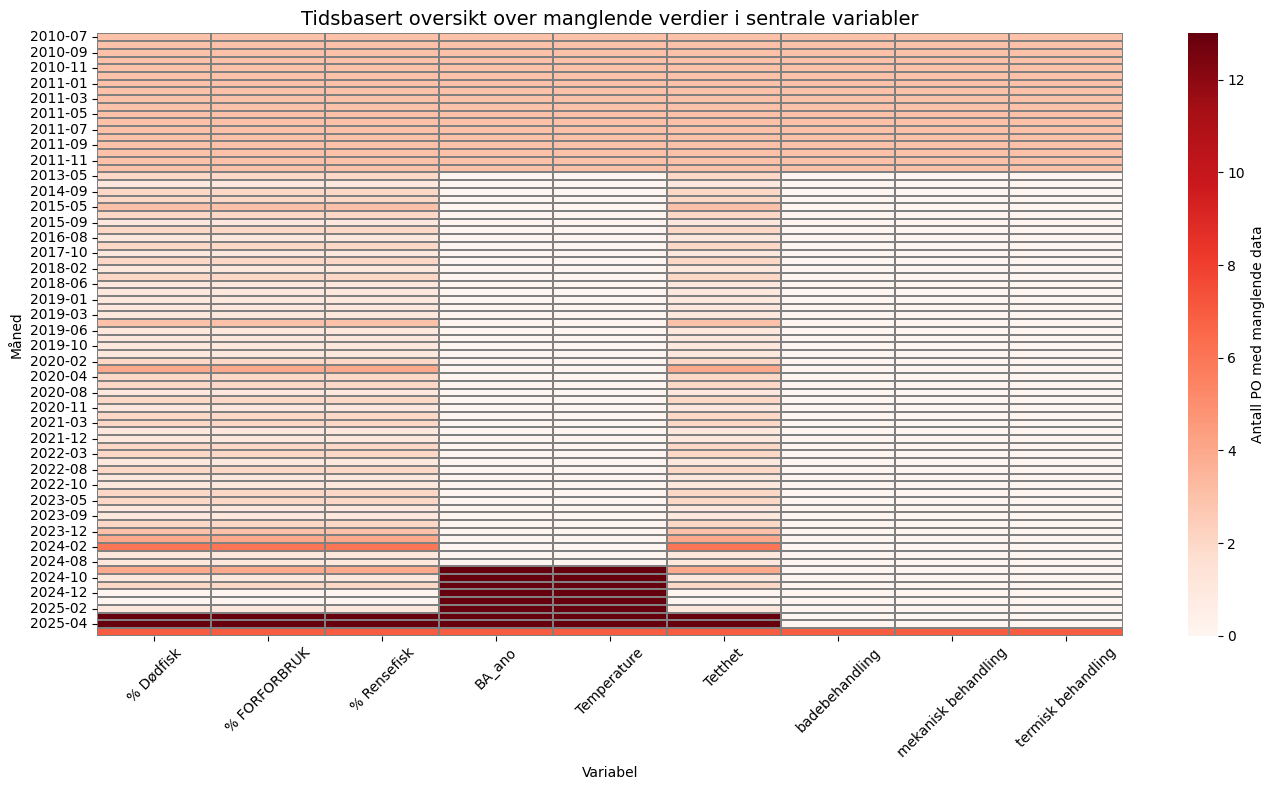

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Last inn og forbered data ===
df = pd.read_csv("data/processed/summary_statistics.csv", sep=";")
df["Dato"] = pd.to_datetime(df["Dato"])
df["måned"] = df["Dato"].dt.to_period("M").astype(str)
df["PO"] = df["PO"].astype("category")

# === Kombiner sykdomsvariabler til én samlet ===
# OBS: Fjernet kombinasjon av PD, ILA, SIMFP og BKD siden de ikke finnes i datasettet
# Du må legge til denne koden hvis du får disse kolonnene senere.

# === Viktige variabler for oversikt ===
viktige_kolonner = [
    "Temperature", "% Dødfisk", "Tetthet", "BA_ano", "% FORFORBRUK",
    "% Rensefisk", "badebehandling", "mekanisk behandling", "termisk behandling"
]

# === Lag langformat og filtrer manglende verdier ===
melted = df[["måned", "PO"] + viktige_kolonner].melt(
    id_vars=["måned", "PO"], var_name="Variabel", value_name="Verdi"
)
mangler = melted[melted["Verdi"].isnull()]

# === Tell mangler per måned og variabel ===
pivot_mangler = (
    mangler.groupby(["måned", "Variabel"])
    .size()
    .reset_index(name="Antall Mangler")
    .pivot_table(index="måned", columns="Variabel", values="Antall Mangler", fill_value=0)
)

# === Visualiser heatmap ===
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_mangler,
    cmap="Reds",
    linewidths=0.3,
    linecolor="gray",
    cbar_kws={"label": "Antall PO med manglende data"}
)
plt.title("Tidsbasert oversikt over manglende verdier i sentrale variabler", fontsize=14)
plt.xlabel("Variabel")
plt.ylabel("Måned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
